<a href="https://colab.research.google.com/github/khangsheng1/PyTorch-Tutorial/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# https://www.tensorflow.org/datasets/catalog/mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
# Convert MNIST to 4-D tensor (# images, height, width, color channel)
transform = transforms.ToTensor()

In [63]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [64]:
# TEst Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [65]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [66]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [67]:
# Create a small batch size for images ... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [68]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
# 6 outputs from conv1 to 6 inputs in conv2
conv2 = nn.Conv2d(6, 16, 3, 1)

In [69]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break

In [70]:
X_train.shape

torch.Size([1, 28, 28])

In [71]:
x = X_train.view(1,1,28,28)

In [72]:
# Perform 1st convolution
x = F.relu(conv1(x)) # rectified linear unit for our activation function

In [73]:
# [1 image, 6 is the filters we asked for, 26x26 is the image size]
# not 28 anymore because we didn't keep padding, in real world cases we will
# probably keep this padding
x.shape

torch.Size([1, 6, 26, 26])

In [74]:
# Pass thru the pooling layer
x = F.max_pool2d(x,2,2) # kernal of 2 and stride of 2

In [75]:
# [1 image, 6 filters, 13x13: 26/2=13 from pooling]
x.shape

torch.Size([1, 6, 13, 13])

In [76]:
# Second convolutional layer
x = F.relu(conv2(x))

In [77]:
# [1 image, 16 filters defined for conv2, 11x11]
# We didn't set padding so we lose 2 pixels
x.shape

torch.Size([1, 16, 11, 11])

In [78]:
# Pooling Layer 2
x = F.max_pool2d(x, 2,2)

In [79]:
# 11/2 = 5.5 but we have 5, round down because you can't invent data
# to round up
x.shape

torch.Size([1, 16, 5, 5])

In [80]:
# Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120) # 5x5x16 as input from pool layer 2
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) # 10 is the number of classes we have

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten out data
    X = X.view(-1,16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim = 1)

In [81]:
# Create an instance of our Model
torch.manual_seed(41) # set random seed
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [82]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
# The smaller the lr, the longer its gonna take to train
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [83]:
import time
start_time = time.time()

# Create variables to track progress
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Create for loops of Epochs
for i in range(epochs):
  trn_correct = 0
  tst_correct = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    # start our batches at 1
    b+=1
    # get predictions from training set, not flattened
    y_pred = model(X_train)
    # calculate loss. compare predictions to correct answers in y_train
    loss = criterion(y_pred, y_train)
    # add up the nubmer of correct predictions
    predicted = torch.max(y_pred.data, 1)[1]
    # how many we got correct from this batch. (True = 1, False = 0) summed up
    batch_correct = (predicted == y_train).sum()
    # add up the number of correct predictions
    trn_correct += batch_correct

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out our results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss}')

  train_losses.append(loss)
  train_correct.append(trn_correct)
  # Test
  # No gradient so we don't update our weights and biases with test data
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_correct += (predicted == y_test).sum()
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_correct)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.1599934995174408
Epoch: 0 Batch: 1200 Loss: 0.18979528546333313
Epoch: 0 Batch: 1800 Loss: 0.5580862760543823
Epoch: 0 Batch: 2400 Loss: 0.2070152312517166
Epoch: 0 Batch: 3000 Loss: 0.006888664327561855
Epoch: 0 Batch: 3600 Loss: 0.33112621307373047
Epoch: 0 Batch: 4200 Loss: 0.004664934705942869
Epoch: 0 Batch: 4800 Loss: 0.0020317500457167625
Epoch: 0 Batch: 5400 Loss: 0.06558699160814285
Epoch: 0 Batch: 6000 Loss: 0.000513441045768559
Epoch: 1 Batch: 600 Loss: 0.004773168824613094
Epoch: 1 Batch: 1200 Loss: 0.30684694647789
Epoch: 1 Batch: 1800 Loss: 0.0025840331800282
Epoch: 1 Batch: 2400 Loss: 0.004851708188652992
Epoch: 1 Batch: 3000 Loss: 0.05095291882753372
Epoch: 1 Batch: 3600 Loss: 0.29904529452323914
Epoch: 1 Batch: 4200 Loss: 0.020275484770536423
Epoch: 1 Batch: 4800 Loss: 0.0018002415308728814
Epoch: 1 Batch: 5400 Loss: 0.0003511425748001784
Epoch: 1 Batch: 6000 Loss: 0.16817066073417664
Epoch: 2 Batch: 600 Loss: 0.044435493648052216
Epoch: 2 B

In [84]:
train_losses = [tl.item() for tl in train_losses]

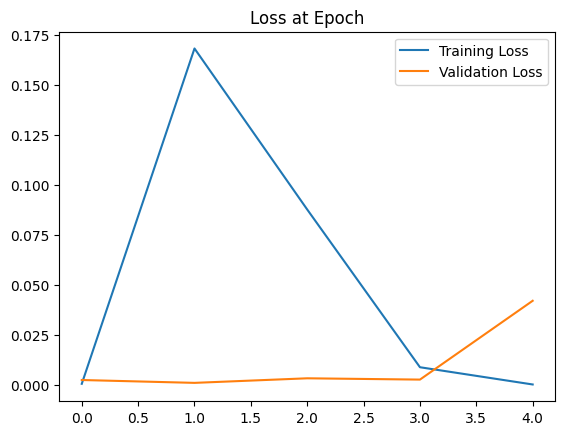

In [88]:
# Graph the loss at epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Epoch')
plt.legend()

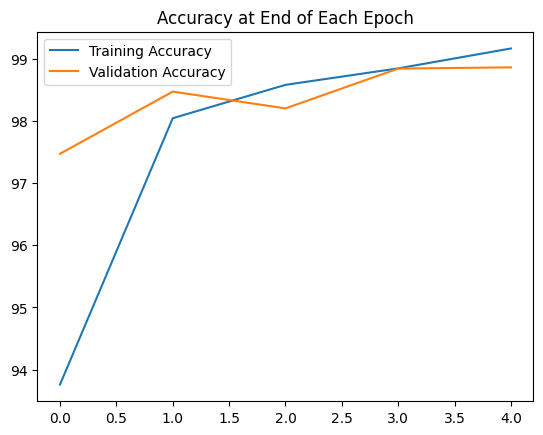

In [89]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at End of Each Epoch")
plt.legend()

In [90]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [145]:
with torch.no_grad():
  correct = 0
  wrong = 0
  wrong_indices = []
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()
    wrong += (predicted != y_test).sum()
    wrong_indices = (predicted != y_test).nonzero()


In [169]:
# Test for correct
print(f'{correct.item()/len(test_data)*100}% correct!')
print(f'{wrong.item()/len(test_data)*100}% wrong. :(')
wrong_indicies_aslist = wrong_indices.tolist()
wrong_indicies_aslist_formatted_string = ', '.join(map(str, wrong_indicies_aslist))
print(f'\nThese are the indicies of all wrong predictions: \
\n{wrong_indicies_aslist_formatted_string}')


98.86% correct!
1.1400000000000001% wrong. :(

These are the indicies of all wrong predictions: 
[8], [247], [321], [340], [359], [449], [582], [659], [786], [900], [947], [965], [1014], [1033], [1112], [1178], [1226], [1242], [1260], [1319], [1337], [1393], [1459], [1522], [1549], [1709], [1721], [1737], [1843], [1878], [1901], [1955], [1987], [2035], [2040], [2043], [2070], [2098], [2135], [2195], [2369], [2406], [2414], [2462], [2488], [2515], [2607], [2654], [2720], [2760], [2770], [2896], [2921], [2953], [2959], [2970], [2995], [3225], [3251], [3288], [3289], [3422], [3451], [3503], [3520], [3558], [3559], [3626], [3727], [3869], [3941], [3985], [4027], [4176], [4238], [4248], [4265], [4571], [4639], [4699], [4712], [4740], [4761], [4807], [4814], [4860], [5600], [5937], [5981], [5982], [6555], [6597], [6598], [6625], [6651], [6706], [6847], [7574], [7619], [7797], [7927], [8160], [8527], [9009], [9015], [9634], [9642], [9664], [9679], [9729], [9770], [9792], [9839], [9888]


In [160]:
# Grab an image of a number
grab_num = test_data[1] # tensor with an image ... at end, it prints the label
#grab_num

In [161]:
# Grab just the data
test_num = grab_num[0].reshape(28,28)
#test_num

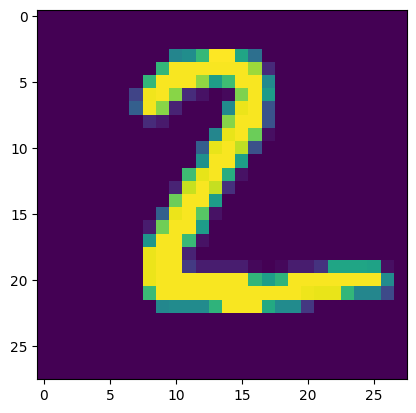

In [162]:
plt.imshow(test_num)

In [163]:
# Pass the image through out model
model.eval()
with torch.no_grad():
  new_prediction = model(test_num.view(1,1,28,28))


In [164]:
# Check the new prediction ... get probabilites
print(new_prediction)
print('\nThese are probabilites of the test number being a 0-9.\
 \nThe largest probability is what the model predicts the input \
 to be. \nIt is hard to see here so we can use the argmax function \
 to find the predicted label.')

tensor([[-2.0654e+01, -1.3679e+01, -1.7881e-06, -2.0578e+01, -1.4675e+01,
         -3.1072e+01, -1.5753e+01, -1.9805e+01, -2.3649e+01, -2.7476e+01]])

These are probabilites of the test number being a 0-9. 
The largest probability is what the model predicts the input  to be. 
It is hard to see here so we can use the argmax function  to find the predicted label.


In [165]:
print(f'The predicted number is {new_prediction.argmax()}. The \
actual number is {grab_num[1]}')

The predicted number is 2. The actual number is 2
